# Handwritten digits with spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Digit_Spark').getOrCreate()

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

%matplotlib inline
sns.set()

In [4]:
train = spark.read.csv('train.csv',header=True,inferSchema=True)
test = spark.read.csv('test.csv',header=True,inferSchema=True)

In [5]:
train.limit(5).toPandas()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.limit(5).toPandas()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_numpy = np.array(train.select([c for c in train.columns if c != 'label']).toPandas())
y_numpy = np.array(train.select('label').toPandas())

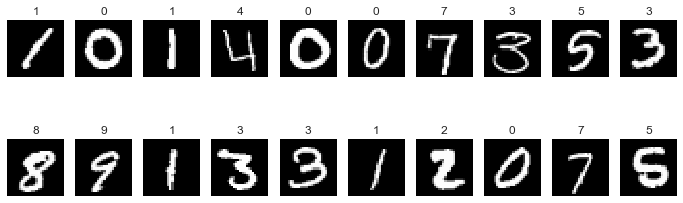

In [26]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 4))
plt.gray() 
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(X_numpy[idx].reshape(28,28)) 
    ax.set_title(int(y_numpy[idx]))
    ax.axis('off')

In [29]:
df_train, df_test = train.randomSplit([0.8, 0.2], seed=42)

# Functions in the pipeline
evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='f1')
assembler = VectorAssembler(inputCols=[c for c in train.columns if c not in ['label']], outputCol='features')

# classifier
rfc = RandomForestClassifier(featuresCol='features', labelCol='label')

# Grid for each classifier
paramGrid_rfc = ParamGridBuilder().addGrid(rfc.numTrees, [50,100]).build()

def test_classifiers(clf, paramGrid):
    # Definition of pipeline
    pipeline = Pipeline(stages=[assembler, clf])
    # Definition of the cross validator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid, 
        evaluator=evaluator, 
        numFolds=3)
    print('training classifier: {}\n'.format(clf))
    model = cv.fit(df_train)
    pred_ml_test = model.transform(df_test)
    pred_ml_test_pd = pred_ml_test.toPandas()
    print(classification_report(pred_ml_test_pd.prediction, pred_ml_test_pd.label))
    return model

In [30]:
model = test_classifiers(rfc, paramGrid_rfc)

training classifier: RandomForestClassifier_5057b2f8f2c7

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       872
         1.0       0.98      0.83      0.90      1076
         2.0       0.85      0.88      0.87       746
         3.0       0.84      0.78      0.81       912
         4.0       0.83      0.88      0.85       761
         5.0       0.65      0.92      0.76       544
         6.0       0.90      0.87      0.89       813
         7.0       0.89      0.87      0.88       914
         8.0       0.77      0.86      0.81       729
         9.0       0.83      0.77      0.80       873

    accuracy                           0.85      8240
   macro avg       0.85      0.86      0.85      8240
weighted avg       0.86      0.85      0.85      8240



In [49]:
result_test = model.transform(df_test)
result_test = result_test.withColumn('prediction_results', result_test.label - result_test.prediction)

check_res = udf(lambda x: True if x==0 else False)
result_test = result_test.withColumn('prediction_results', check_res(result_test.prediction_results))

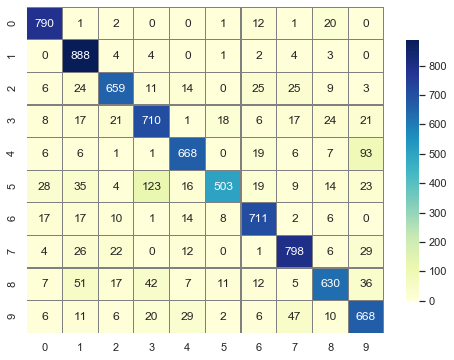

In [48]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(
        np.array(result_test.select('label').toPandas()), 
        np.array(result_test.select('prediction').toPandas())), 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d'
)

In [51]:
X_test_numpy = np.array(test.toPandas())
y_test_numpy = np.array(model.transform(test).select('prediction').toPandas())

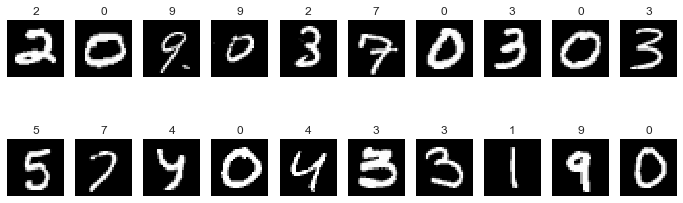

In [52]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 4))
plt.gray() 
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(X_test_numpy[idx].reshape(28,28)) 
    ax.set_title(int(y_test_numpy[idx]))
    ax.axis('off')